In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('hackathon_data_main_with_numbers.csv', sep=';')

# Просмотр структуры данных
print("Размерность данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

In [ ]:
# Преобразование текстовых данных в числовые
label_encoders = {}

# Кодируем категориальные переменные
categorical_columns = ['Аэропорт вылета', 'Аэропорт прилета', 'Тип ВС', 'Код кабины']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Преобразуем дату и время
df['Дата вылета'] = pd.to_datetime(df['Дата вылета']).astype('int64') // 10**9
df['Время вылета'] = pd.to_datetime(df['Время вылета']).dt.hour * 3600 + pd.to_datetime(df['Время вылета']).dt.minute * 60
df['Время прилета'] = pd.to_datetime(df['Время прилета']).dt.hour * 3600 + pd.to_datetime(df['Время прилета']).dt.minute * 60

# Заменяем запятые на точки в числовых столбцах и преобразуем
numeric_columns = ['LF Кабина', 'Доход пасс']
for col in numeric_columns:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# Определяем входные и выходные признаки
input_columns = ['Дата вылета', 'Номер рейса', 'Аэропорт вылета', 'Аэропорт прилета',
                'Время вылета', 'Время прилета', 'Тип ВС', 'Код кабины']

output_columns = ['Емкость кабины', 'LF Кабина', 'Бронирования по кабинам', 'Доход пасс', 'Пассажиры']

# Удаляем строки с пропущенными значениями
df_clean = df[input_columns + output_columns].dropna()

X = df_clean[input_columns].values
y = df_clean[output_columns].values

# Стандартизация данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print(f"Размерность X: {X_scaled.shape}")
print(f"Размерность y: {y_scaled.shape}")

In [ ]:
# Подготовка данных для последовательностей (группировка по рейсам)
# Создаем последовательности по 3 временных шага (кабины C, W, Y)
def create_sequences(X, y, sequence_length=3):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length + 1, sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i:i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Создаем последовательности
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled)

print(f"Размерность X_sequences: {X_sequences.shape}")
print(f"Размерность y_sequences: {y_sequences.shape}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

In [ ]:
def create_cnn_lstm_model(input_shape, output_shape):
    model = Sequential()

    # CNN слои для извлечения локальных паттернов
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                    input_shape=input_shape, padding='same'))
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))
    model.add(Dropout(0.3))

    # LSTM слои для анализа временных зависимостей
    model.add(LSTM(50, return_sequences=True, activation='relu'))
    model.add(Dropout(0.3))
    model.add(LSTM(25, activation='relu'))
    model.add(Dropout(0.3))

    # Полносвязные слои
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(output_shape))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])

    return model

# Создаем модель
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
output_shape = y_train.shape[1] * y_train.shape[2]  # flatten output

model = create_cnn_lstm_model(input_shape, output_shape)
model.summary()

In [ ]:
# Изменяем форму y для обучения
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

# Колбэк для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

# Обучение модели
history = model.fit(
    X_train, y_train_flat,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test_flat),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.9523 - mae: 0.7976 - val_loss: 0.7149 - val_mae: 0.6118
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6699 - mae: 0.6056 - val_loss: 0.5742 - val_mae: 0.5176
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5469 - mae: 0.5264 - val_loss: 0.4717 - val_mae: 0.4533
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4757 - mae: 0.4843 - val_loss: 0.4296 - val_mae: 0.4289
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4525 - mae: 0.4603 - val_loss: 0.4173 - val_mae: 0.4214
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4242 - mae: 0.4489 - val_loss: 0.3960 - val_mae: 0.3980
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3970 - mae: 0.4277 - val_loss: 0.3762 - val_mae: 0.3836
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3858 - mae: 0.4200 - val_loss: 0.3745 - val_mae: 0.3815
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

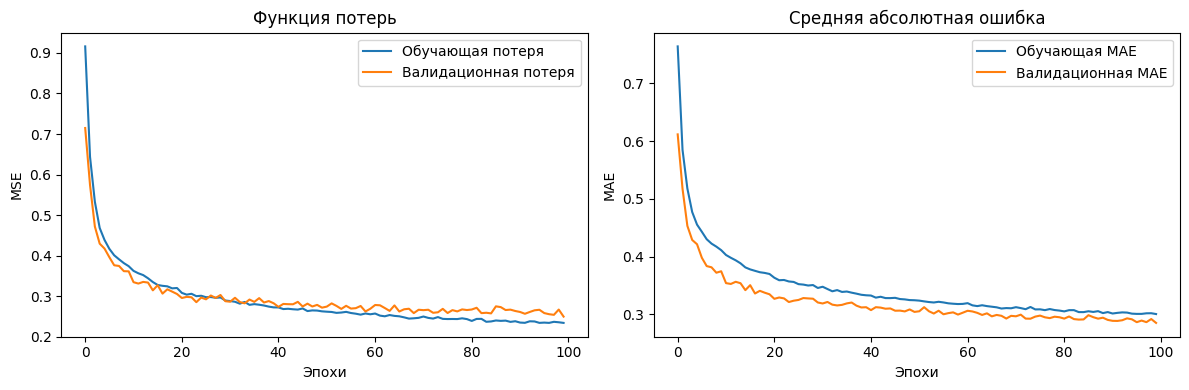

In [ ]:
# Графики обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Обучающая MAE')
plt.plot(history.history['val_mae'], label='Валидационная MAE')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпохи')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Предсказания на тестовой выборке
y_pred_flat = model.predict(X_test)
y_pred = y_pred_flat.reshape(y_test.shape)

# Обратное преобразование масштабирования
y_test_original = []
y_pred_original = []

for i in range(len(y_test)):
    # Восстанавливаем исходный масштаб для каждой последовательности
    y_test_seq = scaler_y.inverse_transform(y_test[i])
    y_pred_seq = scaler_y.inverse_transform(y_pred[i])

    y_test_original.append(y_test_seq)
    y_pred_original.append(y_pred_seq)

y_test_original = np.array(y_test_original)
y_pred_original = np.array(y_pred_original)

# Вычисление метрик
def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(mse)

    return mse, mae, rmse

mse, mae, rmse = calculate_metrics(y_test_original, y_pred_original)
print(f"Результаты модели:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Результаты модели:
MSE: 27773712.13
MAE: 1234.98
RMSE: 5270.08


In [ ]:
# Демонстрация предсказаний для нескольких примеров
print("\nДемонстрация предсказаний:")
print("="*80)

for i in range(min(3, len(X_test))):
    print(f"\nПример {i+1}:")
    print("-" * 40)

    # Информация о входных данных
    original_input = scaler_X.inverse_transform(X_test[i])
    print("Входные данные (первые 3 признака):")
    for j, row in enumerate(original_input):
        cabin_type = ['C', 'W', 'Y'][j]
        print(f"  Кабина {cabin_type}: Дата={row[0]:.0f}, Рейс={row[1]:.0f}, Вылет={row[4]:.0f}")

    # Сравнение предсказаний с реальными значениями
    print("\nСравнение предсказаний:")
    print("Кабина | Реальные значения vs Предсказания")
    print("-" * 50)

    for j in range(3):
        cabin_type = ['C', 'W', 'Y'][j]
        real_values = y_test_original[i, j]
        pred_values = y_pred_original[i, j]

        print(f"{cabin_type:6} | Емкость: {real_values[0]:3.0f} vs {pred_values[0]:3.0f} | "
              f"LF: {real_values[1]:.2f} vs {pred_values[1]:.2f} | "
              f"Доход: {real_values[3]:6.0f} vs {pred_values[3]:6.0f}")

# Сохранение модели
model.save('cnn_lstm_flight_model.h5')
print(f"\nМодель сохранена как 'cnn_lstm_flight_model.h5'")

# Сохранение scalers для будущего использования
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Scalers и энкодеры сохранены")


Демонстрация предсказаний:

Пример 1:
----------------------------------------
Входные данные (первые 3 признака):
  Кабина C: Дата=1739318400, Рейс=1055, Вылет=52800
  Кабина W: Дата=1739318400, Рейс=1129, Вылет=21900
  Кабина Y: Дата=1739318400, Рейс=1129, Вылет=21900

Сравнение предсказаний:
Кабина | Реальные значения vs Предсказания
--------------------------------------------------
C      | Емкость: 150 vs 147 | LF: 0.99 vs 0.96 | Доход:   7447 vs   8765
W      | Емкость:   8 vs   9 | LF: 0.38 vs 0.46 | Доход:    756 vs   1965
Y      | Емкость: 150 vs 150 | LF: 1.00 vs 0.98 | Доход:   6624 vs  10055

Пример 2:
----------------------------------------
Входные данные (первые 3 признака):
  Кабина C: Дата=1740528000, Рейс=6568, Вылет=67500
  Кабина W: Дата=1740528000, Рейс=6568, Вылет=67500
  Кабина Y: Дата=1740528000, Рейс=6574, Вылет=74700

Сравнение предсказаний:
Кабина | Реальные значения vs Предсказания
--------------------------------------------------
C      | Емкость:   8 vs

In [ ]:
def predict_new_data(model, new_data, scaler_X, scaler_y, label_encoders):
    """
    Функция для предсказания на новых данных
    """
    # Преобразование новых данных
    new_data_encoded = new_data.copy()

    # Кодирование категориальных переменных
    for col, le in label_encoders.items():
        if col in new_data_encoded.columns:
            # Для новых значений, которых нет в обучающих данных
            new_data_encoded[col] = new_data_encoded[col].apply(
                lambda x: le.transform([x])[0] if x in le.classes_ else len(le.classes_)
            )

    # Преобразование даты и времени
    if 'Дата вылета' in new_data_encoded.columns:
        new_data_encoded['Дата вылета'] = pd.to_datetime(new_data_encoded['Дата вылета']).astype('int64') // 10**9

    if 'Время вылета' in new_data_encoded.columns:
        new_data_encoded['Время вылета'] = pd.to_datetime(new_data_encoded['Время вылета']).dt.hour * 3600 + pd.to_datetime(new_data_encoded['Время вылета']).dt.minute * 60

    if 'Время прилета' in new_data_encoded.columns:
        new_data_encoded['Время прилета'] = pd.to_datetime(new_data_encoded['Время прилета']).dt.hour * 3600 + pd.to_datetime(new_data_encoded['Время прилета']).dt.minute * 60

    # Масштабирование
    X_new = scaler_X.transform(new_data_encoded[input_columns].values)

    # Предсказание
    X_new_seq = X_new.reshape(1, 1, -1)  # Формируем последовательность
    y_pred_scaled = model.predict(X_new_seq)
    y_pred_flat = y_pred_scaled.reshape(3, -1)
    y_pred_original = scaler_y.inverse_transform(y_pred_flat)

    return y_pred_original

# Пример использования функции предсказания
print("\nПример предсказания для новых данных:")
print("="*50)

# Создаем тестовые новые данные
new_data_example = pd.DataFrame({
    'Дата вылета': ['2025-06-16'],
    'Номер рейса': [1190],
    'Аэропорт вылета': ['SVO'],
    'Аэропорт прилета': ['KZN'],
    'Время вылета': ['09:10'],
    'Время прилета': ['10:50'],
    'Тип ВС': ['32B'],
    'Код кабины': ['W']
})

try:
    predictions = predict_new_data(model, new_data_example, scaler_X, scaler_y, label_encoders)
    print("Предсказания выполнены успешно!")
    print("Результаты:")
    for i, cabin in enumerate(['W']):
        print(f"Кабина {cabin}: Емкость={predictions[i,0]:.0f}, LF={predictions[i,1]:.2f}, "
              f"Бронирования={predictions[i,2]:.0f}, Доход={predictions[i,3]:.0f}, "
              f"Пассажиры={predictions[i,4]:.0f}")
except Exception as e:
    print(f"Ошибка при предсказании: {e}")


Пример предсказания для новых данных:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Предсказания выполнены успешно!
Результаты:
Кабина W: Емкость=102, LF=0.66, Бронирования=66, Доход=6663, Пассажиры=67
